In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import scipy, os, glob, sys

In [2]:
ft_path = '/Users/jvanbaar/Dropbox (Brown)/Python'
sys.path.append(ft_path)
import FigureTools

In [3]:
blockDat = pd.read_csv('/Users/jvanbaar/Dropbox (Brown)/Postdoc FHL/JEROEN/SOC_STRUCT_LEARN/Study2_EyeTracking'
               +'/Data/Cleaned/blockDat.csv',index_col = 0, dtype={ 'subID':str})
subIDs = blockDat['subID'].unique()
print(len(subIDs))
blockDat.head()

50


,subID,Type_Total,Type,Variant,Confidence,Score
0,5005,opt_inv,opt,inv,46.65625,0.40625
1,5005,opt_nat,opt,nat,82.93750,0.90625
2,5005,pess_inv,pes,_inv,64.40625,0.43750
3,5005,pess_nat,pes,_nat,91.09375,0.93750
4,5006,opt_inv,opt,inv,47.21875,0.40625


In [4]:
combs = []
for model1 in ['0','1']:
    for model2 in ['0','1']:
        for model3 in ['0','1']:
            for model4 in ['0','1']:
                combs.append(model1+model2+model3+model4)
combs = combs[1:]
# combs

In [6]:
niter = 5
results_Feature_RL = pd.DataFrame()
for subID in subIDs:
    print(subID, end=',')
    filename = glob.glob('FeatureRL/Results/results_06-Sep-2019/subInd-*_subID-*%s_niter-%i_results.csv'%(
        subID, niter))[0]
#     print(filename)
    results = pd.read_csv(filename,header=0, index_col=None, dtype = {'subID':str})
    results['subID'] = subID
    results_Feature_RL = results_Feature_RL.append(results.iloc[:119,:])
results_Feature_RL = results_Feature_RL.reset_index(drop=True)

5005,5006,5007,5008,5009,5010,5011,5012,5013,5014,5015,5016,5017,5018,5019,5020,5021,5022,5023,5024,5025,5026,5027,5028,5029,5030,5031,5032,5033,5034,5035,5036,5037,5038,5039,5040,5041,5042,5043,5044,5045,5046,5047,5048,5049,5050,5051,5052,5053,5054,

##### Parse feature combination

In [8]:
results_Feature_RL['combInd'].unique()

array([1, 2, 3, 4, 5, 6, 7, 8])

## Fix error in feature combination indices (combInd): mapping is off

In [9]:
mapping = dict(zip(np.arange(1,9),[4, 5, 6, 7, 12, 13, 14, 15]))
mapping

{1: 4, 2: 5, 3: 6, 4: 7, 5: 12, 6: 13, 7: 14, 8: 15}

In [12]:
results_Feature_RL['combInd_fixed'] = results_Feature_RL['combInd'].apply(lambda x: mapping[x])

In [13]:
results_Feature_RL['comb'] = [combs[combInd-1] for combInd in results_Feature_RL['combInd_fixed'].values]
results_Feature_RL.head()

,fitTo,combInd,asymm_LR,bounded_weights,bestNLL,param1,param2,param3,param4,param5,param6,param7,param8,param9,param10,subID,combInd_fixed,comb
0,1,1,0,0,71.47,0.60,0.36,3.89,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5005,4,0100
1,1,1,0,1,70.73,1.81,0.18,8.66,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5005,4,0100
2,1,1,1,0,71.44,1.51,0.98,0.15,10.04,NaN,NaN,NaN,NaN,NaN,NaN,5005,4,0100
3,1,1,1,1,70.70,2.45,1.93,0.13,11.85,NaN,NaN,NaN,NaN,NaN,NaN,5005,4,0100
4,1,2,0,0,65.01,0.51,0.42,4.68,2.17,NaN,NaN,NaN,NaN,NaN,NaN,5005,5,0101


In [14]:
paramCols = []
cols = list(results_Feature_RL.columns.values)
for ni,name in enumerate(cols):
    if 'param' in name:
        paramCols.append(ni)
paramCols = [cols[pc] for pc in paramCols]

In [15]:
def penalizedModelFit(NLL,nParams, whichOne = 'both'):
    AIC = 2*nParams - 2 * -NLL
    BIC = nParams * np.log(64) - 2 * -NLL
    # see https://en.wikipedia.org/wiki/Bayesian_information_criterion and 
    # https://en.wikipedia.org/wiki/Akaike_information_criterion
    if whichOne == 'both':
        return AIC, BIC
    elif whichOne == 'AIC':
        return AIC
    elif whichOne == 'BIC':
        return BIC
    else:
        ValueError('invalid value for argument whichOne')

In [16]:
for i in results_Feature_RL.index:
#     fitToNParams = (results_all.loc[i,'fitTo']-1)*3
#     combNParams = combs[(results_all.loc[i,'combInd']-1)].count('1')
#     asymm_LRNParams = (results_all.loc[i,'asymm_LR'])
#     nParams = 2 + combNParams + asymm_LRNParams + fitToNParams
    nParams = sum(~np.isnan(results_Feature_RL.loc[i,paramCols].values.astype(float)))
#     print(nParams)
    AIC, BIC = penalizedModelFit(results_Feature_RL.loc[i,'bestNLL'],nParams)
#     print(BIC)
    results_Feature_RL.loc[i,'AIC'] = AIC
    results_Feature_RL.loc[i,'BIC'] = BIC

In [17]:
results_Feature_RL['bestModel'] = False
for subID in results_Feature_RL['subID'].unique():
    subDat = results_Feature_RL.query('subID == @subID'
                                     ).sort_values(by='BIC',ascending=True).copy()
    bestModel = subDat.iloc[0]
    bestBIC = bestModel['BIC']
    results_Feature_RL.loc[(results_Feature_RL['subID']==subID) & 
                           (results_Feature_RL['BIC']==bestBIC),'bestModel'] = True

##### 50 subjects * 8 combs * asymm_LR * bounded_weights = 1600:

In [18]:
results_Feature_RL.shape

(1600, 21)

In [19]:
results_Feature_RL.head()

,fitTo,combInd,asymm_LR,bounded_weights,bestNLL,param1,param2,param3,param4,param5,...,param7,param8,param9,param10,subID,combInd_fixed,comb,AIC,BIC,bestModel
0,1,1,0,0,71.47,0.60,0.36,3.89,NaN,NaN,...,NaN,NaN,NaN,NaN,5005,4,0100,148.94,155.416649,False
1,1,1,0,1,70.73,1.81,0.18,8.66,NaN,NaN,...,NaN,NaN,NaN,NaN,5005,4,0100,147.46,153.936649,False
2,1,1,1,0,71.44,1.51,0.98,0.15,10.04,NaN,...,NaN,NaN,NaN,NaN,5005,4,0100,150.88,159.515532,False
3,1,1,1,1,70.70,2.45,1.93,0.13,11.85,NaN,...,NaN,NaN,NaN,NaN,5005,4,0100,149.40,158.035532,False
4,1,2,0,0,65.01,0.51,0.42,4.68,2.17,NaN,...,NaN,NaN,NaN,NaN,5005,5,0101,138.02,146.655532,False


In [20]:
results_Feature_RL.to_csv('FeatureRL/Results/results_06-Sep-2019/results_all.csv')

## Single subject

In [21]:
subID = '5005'
results_Feature_RL.query('subID == @subID & comb == "1111"')

,fitTo,combInd,asymm_LR,bounded_weights,bestNLL,param1,param2,param3,param4,param5,...,param7,param8,param9,param10,subID,combInd_fixed,comb,AIC,BIC,bestModel
28,1,8,0,0,48.45,0.57,0.57,1.14,3.22,3.52,...,NaN,NaN,NaN,NaN,5005,15,1111,108.90,121.853299,False
29,1,8,0,1,46.37,3.47,0.18,2.33,13.44,11.41,...,NaN,NaN,NaN,NaN,5005,15,1111,104.74,117.693299,False
30,1,8,1,0,48.41,1.29,1.47,0.24,2.35,7.17,...,-2.46,NaN,NaN,NaN,5005,15,1111,110.82,125.932182,False
31,1,8,1,1,43.40,3.35,1.08,0.30,1.99,14.83,...,2.91,NaN,NaN,NaN,5005,15,1111,100.80,115.912182,False


## Model comparison overall

##### All models – BIC

In [22]:
plotDat = results_Feature_RL.query('fitTo == 1 & asymm_LR == 0').copy()
means = plotDat[['comb','bounded_weights','BIC']].groupby(
    ['comb','bounded_weights']).mean().sort_values(by='BIC',ascending=True).reset_index()
combOrder = means['comb'].unique()
print(combOrder)

['0110' '1110' '0111' '1111' '0101' '1101' '0100' '1100']


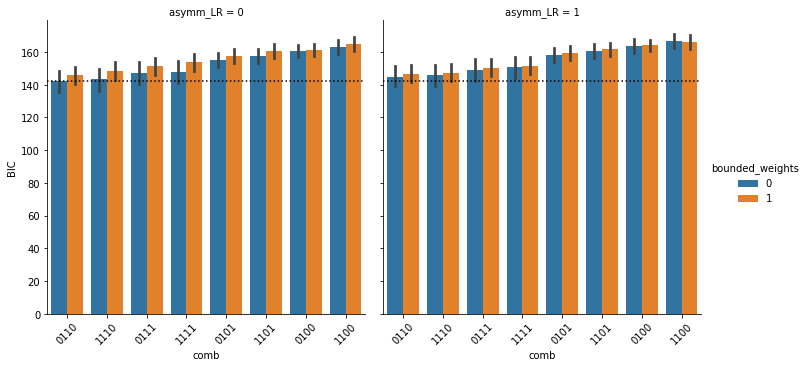

In [24]:
g = sns.catplot(kind='bar',data=results_Feature_RL,x='comb',y='BIC',col = 'asymm_LR',
           hue = 'bounded_weights', order = combOrder, row_order = [1,2])
g.set_xticklabels(rotation=45);
ax1, ax2 = g.axes[0]
ax1.axhline(means.loc[0,'BIC'], color='k',ls=':')
ax2.axhline(means.loc[0,'BIC'], color='k',ls=':');

##### All models - AIC

In [25]:
plotDat = results_Feature_RL.query('fitTo == 1 & asymm_LR == 0').copy()
means = plotDat[['comb','bounded_weights','AIC']].groupby(
    ['comb','bounded_weights']).mean().sort_values(by='AIC',ascending=True).reset_index()
combOrder = means['comb'].unique()
print(combOrder)

['1110' '0110' '1111' '0111' '1101' '0101' '0100' '1100']


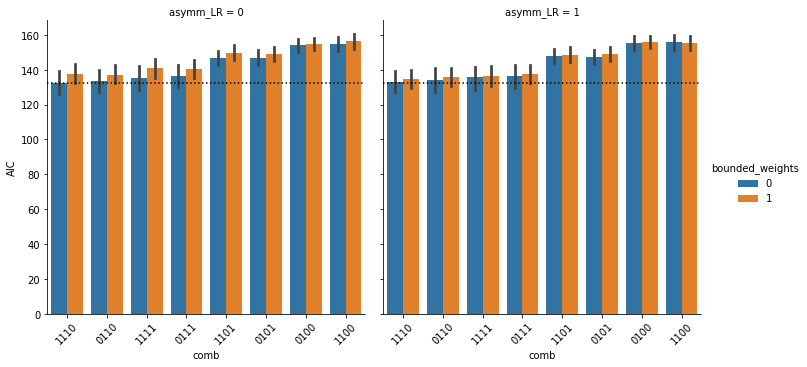

In [26]:
g = sns.catplot(kind='bar',data=results_Feature_RL,
                x='comb',y='AIC',col = 'asymm_LR', 
           hue = 'bounded_weights', order = combOrder, row_order = [1,2])
g.set_xticklabels(rotation=45);
ax1, ax2 = g.axes[0]
ax1.axhline(means.loc[0,'AIC'], color='k',ls=':')
ax2.axhline(means.loc[0,'AIC'], color='k',ls=':');

##### Pretty plot for choice-only

In [28]:
plotDat = results_Feature_RL.query('fitTo == 1 & asymm_LR == 0').copy()
means = plotDat[['comb','asymm_LR','bounded_weights','BIC']].groupby(
    ['comb','asymm_LR','bounded_weights']).mean().sort_values(
    by='BIC',ascending=True).reset_index()
combOrder = means['comb'].unique()
means.head()

,comb,asymm_LR,bounded_weights,BIC
0,0110,0,0,142.331932
1,1110,0,0,143.226015
2,0110,0,1,145.760732
3,0111,0,0,147.170815
4,1111,0,0,148.074099


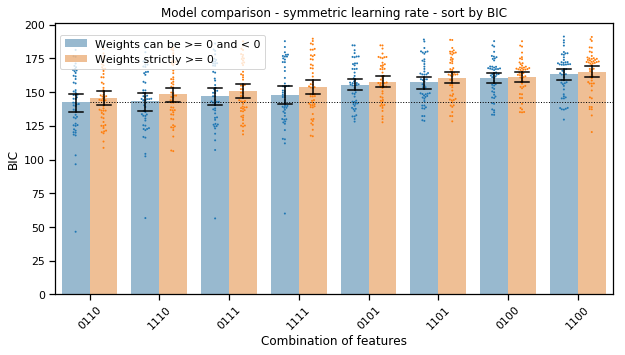

In [30]:
sns.set_context('notebook')
fig, ax = plt.subplots(nrows = 1, ncols = 1, figsize = [10,5]);
sns.barplot(data = plotDat, x = 'comb', y = 'BIC', hue = 'bounded_weights', ax = ax,
            alpha = 0.5, errwidth = 0, zorder = 1, order = combOrder);
[hand, lab] = ax.get_legend_handles_labels();
sns.swarmplot(data = plotDat, x = 'comb', y = 'BIC', hue = 'bounded_weights', dodge = True, ax = ax,
            alpha = 1, size = 2, zorder = 2, order = combOrder);
sns.barplot(data = plotDat, x = 'comb', y = 'BIC', hue = 'bounded_weights', ax = ax,
            alpha = 0, errwidth = 1.5, capsize = .2, errcolor = 'k', zorder = 3, order = combOrder);
plt.plot([0,15],[np.min(means.BIC), np.min(means.BIC)], 'k:', lw=1);
plt.xticks(rotation=45);
# plt.ylim([0,140]);
plt.legend(hand, ['Weights can be >= 0 and < 0','Weights strictly >= 0'], loc = [0.01, 0.83]);
ax.set(xlabel = 'Combination of features', title = 
       'Model comparison - symmetric learning rate - sort by BIC');
# plt.savefig('/Users/jvanbaar/Desktop/modelCompBIC.pdf',bbox_inches='tight');

## Plot with bounded_LR = 0 and asymm_LR = 0, BIC - split by features only

In [31]:
import re

In [32]:
plotDat.head()

,fitTo,combInd,asymm_LR,bounded_weights,bestNLL,param1,param2,param3,param4,param5,...,param7,param8,param9,param10,subID,combInd_fixed,comb,AIC,BIC,bestModel
0,1,1,0,0,71.47,0.60,0.36,3.89,NaN,NaN,...,NaN,NaN,NaN,NaN,5005,4,0100,148.94,155.416649,False
1,1,1,0,1,70.73,1.81,0.18,8.66,NaN,NaN,...,NaN,NaN,NaN,NaN,5005,4,0100,147.46,153.936649,False
4,1,2,0,0,65.01,0.51,0.42,4.68,2.17,NaN,...,NaN,NaN,NaN,NaN,5005,5,0101,138.02,146.655532,False
5,1,2,0,1,64.92,1.88,0.16,11.85,4.44,NaN,...,NaN,NaN,NaN,NaN,5005,5,0101,137.84,146.475532,False
8,1,3,0,0,50.63,0.62,0.63,3.67,3.18,NaN,...,NaN,NaN,NaN,NaN,5005,6,0110,109.26,117.895532,False


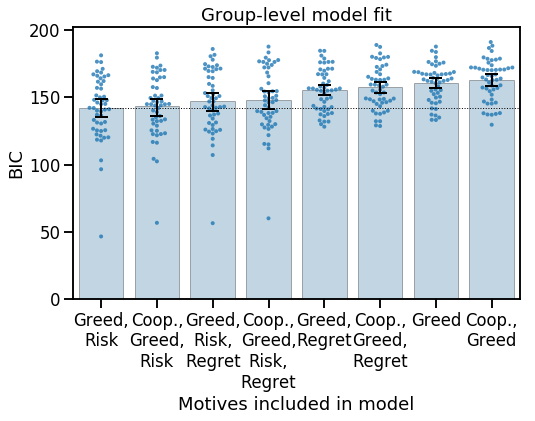

In [35]:
plotDat = results_Feature_RL.query('fitTo == 1 & asymm_LR == 0 & bounded_weights == 0').copy()
letter_list = ['Coop.','Greed','Risk','Regret']
plotDat['comb_letters'] = plotDat['comb'].apply(lambda x: 
                ',\n'.join(letter_list[k] for k in [i.span()[0] for i in re.finditer('1',x)]))

means = plotDat[['comb_letters','BIC']].groupby('comb_letters').mean().sort_values(by='BIC',ascending=True).reset_index()
combOrder = means['comb_letters'].unique()
means.head()

sns.set_context('talk')
fig, ax = plt.subplots(nrows = 1, ncols = 1, figsize = [8,5]);
sns.barplot(data = plotDat, x = 'comb_letters', y = 'BIC', color = sns.color_palette('tab10')[0], ax = ax,
            alpha = 0.3, errwidth = 0, zorder = 1, order = combOrder, edgecolor = 'k', linewidth = 1);
[hand, lab] = ax.get_legend_handles_labels();
sns.swarmplot(data = plotDat, x = 'comb_letters', y = 'BIC', ax = ax, color = sns.color_palette('tab10')[0],
            alpha = .8, size = 4, zorder = 2, order = combOrder);
sns.barplot(data = plotDat, x = 'comb_letters', y = 'BIC', ax = ax,
            alpha = 0, errwidth = 2, capsize = .2, errcolor = 'k', zorder = 3, order = combOrder);
plt.plot([0,15],[np.min(means.BIC), np.min(means.BIC)], 'k:', lw=1);
plt.xticks(rotation=0);
# plt.ylim([0,120]);
# plt.legend(hand, ['Weights can be >= 0 and < 0','Weights strictly >= 0'], loc = [0.01, 0.83]);
ax.set(xlabel = 'Motives included in model', title = 'Group-level model fit');
plt.savefig('/Users/jvanbaar/Desktop/modelCompBIC_motiveLabels_study2.pdf',bbox_inches='tight',
           transparent = True);

## Model comparison per subject - counts (based on BIC)

In [56]:
bestPerSubject = pd.DataFrame()
for sub in results_Feature_RL['subID'].unique():
    subDat = results_Feature_RL.loc[results_Feature_RL['subID']==sub,:].copy()
    subDat = subDat.sort_values(by=['BIC','AIC'], ascending=True)
#     bestBIC = np.min(subDat.BIC)
#     bestModel = subDat.loc[subDat['BIC']==bestBIC,
#                            ['subID','comb','asymm_LR','bounded_weights']].copy()
    bestPerSubject = bestPerSubject.append(subDat.iloc[0])
bestPerSubject = bestPerSubject.reset_index(drop=True)
bestModelCounts = pd.DataFrame(pd.value_counts(bestPerSubject.comb)).reset_index()
bestModelCounts.columns = ['comb','count']
bestModelCounts = bestModelCounts.sort_values(by='count', ascending=False)
bestPerSubject['nDim'] = [sum([char=='1' for 
                   char in bestPerSubject.comb.values[i]]) for i in np.arange(len(bestPerSubject))]
bestModelComplexityCounts = pd.DataFrame(pd.value_counts(bestPerSubject.nDim)).reset_index()
bestModelComplexityCounts.columns = ['nDim','count']
bestModelComplexityCounts = bestModelComplexityCounts.sort_values(by='count', ascending=False)
bestModelComplexityCounts
bestPerSubject.head()

,AIC,BIC,asymm_LR,bestModel,bestNLL,bounded_weights,comb,combInd,combInd_fixed,fitTo,...,param2,param3,param4,param5,param6,param7,param8,param9,subID,nDim
0,95.44,106.234415,0.0,1.0,42.72,1.0,1110,7.0,14.0,1.0,...,0.27,2.24,11.04,10.34,NaN,NaN,NaN,NaN,5005,3
1,99.92,112.873299,1.0,1.0,43.96,0.0,1110,7.0,14.0,1.0,...,2.89,0.29,-5.67,5.54,5.48,NaN,NaN,NaN,5006,3
2,144.86,155.654415,1.0,1.0,67.43,0.0,0110,3.0,6.0,1.0,...,0.01,0.08,20.00,19.34,NaN,NaN,NaN,NaN,5007,2
3,117.98,126.615532,0.0,1.0,54.99,0.0,0110,3.0,6.0,1.0,...,0.51,2.07,3.23,NaN,NaN,NaN,NaN,NaN,5008,2
4,136.46,145.095532,0.0,1.0,64.23,0.0,0110,3.0,6.0,1.0,...,0.20,5.46,5.76,NaN,NaN,NaN,NaN,NaN,5009,2


In [38]:
label_list = ['Coop.','Greed','Risk','Regret']
bestModelCounts['comb_labels'] = bestModelCounts['comb'].apply(lambda x: 
                ',\n'.join(label_list[k] for k in [i.span()[0] for i in re.finditer('1',x)]))
bestModelCounts['pct'] = bestModelCounts['count']/150*100
bestModelComplexityCounts['pct'] = bestModelComplexityCounts['count']/150*100

In [39]:
bestModelCounts_trunc = bestModelCounts.iloc[:6,:]

In [40]:
bmc_other = pd.DataFrame(bestModelCounts.iloc[6:,:].sum()).T[['count','comb_labels','pct']]
bmc_other.loc[0,'comb_labels'] = 'other'
bestModelCounts_aggTrunc = bestModelCounts.iloc[:6,:].append(bmc_other, sort = False)
bestModelCounts_aggTrunc

,comb,count,comb_labels,pct
0,0110,27,"Greed,\nRisk",18
1,1110,12,"Coop.,\nGreed,\nRisk",8
2,0100,4,Greed,2.66667
3,1100,3,"Coop.,\nGreed",2
4,0101,2,"Greed,\nRegret",1.33333
5,1101,1,"Coop.,\nGreed,\nRegret",0.666667
0,NaN,1,other,0.666667


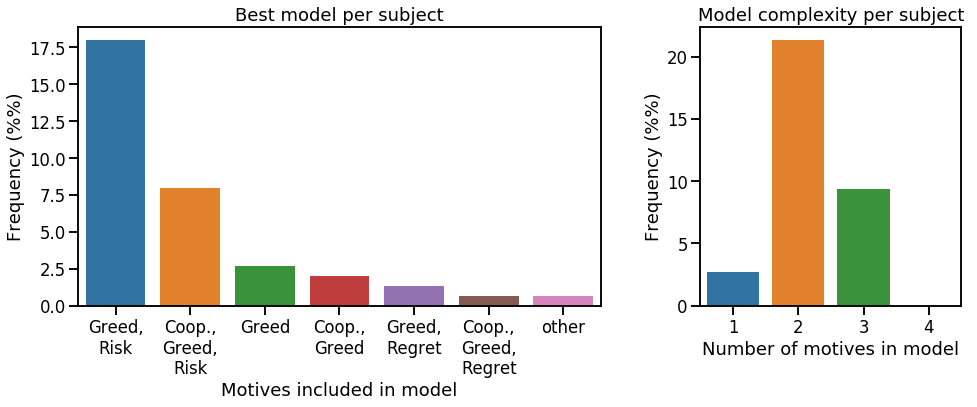

In [41]:
sns.set_context('talk')
fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = [14,6], gridspec_kw = {'width_ratios':[2,1]});
sns.barplot(data = bestModelCounts_aggTrunc, x='comb_labels', y='pct',
            order = bestModelCounts_aggTrunc.comb_labels, ax = ax[0],
           palette = 'tab10')
ax[0].set(xlabel = 'Motives included in model', ylabel = 'Frequency (%%)',
       title = 'Best model per subject');
ax[0].set_xticklabels(ax[0].get_xticklabels(),rotation=0)
sns.barplot(data = bestModelComplexityCounts, x='nDim', y='pct', order = [1,2,3,4], ax = ax[1])
ax[1].set(xlabel = 'Number of motives in model', ylabel = 'Frequency (%%)',
       title = 'Model complexity per subject');
plt.tight_layout()
plt.savefig('/Users/jvanbaar/Desktop/modelComp_perSub_labels_pct_study2.pdf',bbox_inches='tight',
           transparent = True)

In [42]:
bestPerSubject_features = bestPerSubject.copy()
label_list = ['Coop.','Greed','Risk','Regret']
bestPerSubject_features['comb_labels'] = bestPerSubject_features['comb'].apply(lambda x: 
                ',\n'.join(label_list[k] for k in [i.span()[0] for i in re.finditer('1',x)]))
for feature in ['Coop','Greed','Risk','Regret']:
    bestPerSubject_features[feature] = bestPerSubject_features['comb_labels'].apply(lambda x: feature in x)
bestPerSubject_features.head()

,AIC,BIC,asymm_LR,bestModel,bestNLL,bounded_weights,comb,combInd,combInd_fixed,fitTo,...,param7,param8,param9,subID,nDim,comb_labels,Coop,Greed,Risk,Regret
0,95.44,106.234415,0.0,1.0,42.72,1.0,1110,7.0,14.0,1.0,...,NaN,NaN,NaN,5005,3,"Coop.,\nGreed,\nRisk",True,True,True,False
1,99.92,112.873299,1.0,1.0,43.96,0.0,1110,7.0,14.0,1.0,...,NaN,NaN,NaN,5006,3,"Coop.,\nGreed,\nRisk",True,True,True,False
2,144.86,155.654415,1.0,1.0,67.43,0.0,0110,3.0,6.0,1.0,...,NaN,NaN,NaN,5007,2,"Greed,\nRisk",False,True,True,False
3,117.98,126.615532,0.0,1.0,54.99,0.0,0110,3.0,6.0,1.0,...,NaN,NaN,NaN,5008,2,"Greed,\nRisk",False,True,True,False
4,136.46,145.095532,0.0,1.0,64.23,0.0,0110,3.0,6.0,1.0,...,NaN,NaN,NaN,5009,2,"Greed,\nRisk",False,True,True,False


In [43]:
featureCounts = pd.DataFrame(bestPerSubject_features[['Coop','Greed','Risk','Regret']].sum()).reset_index()
featureCounts.columns = ['Motive','Count']
featureCounts['pct'] = featureCounts['Count']/150
featureCounts.sort_values(by='Count', ascending = False, inplace=True)
featureCounts

,Motive,Count,pct
1,Greed,50,0.333333
2,Risk,40,0.266667
0,Coop,16,0.106667
3,Regret,4,0.026667


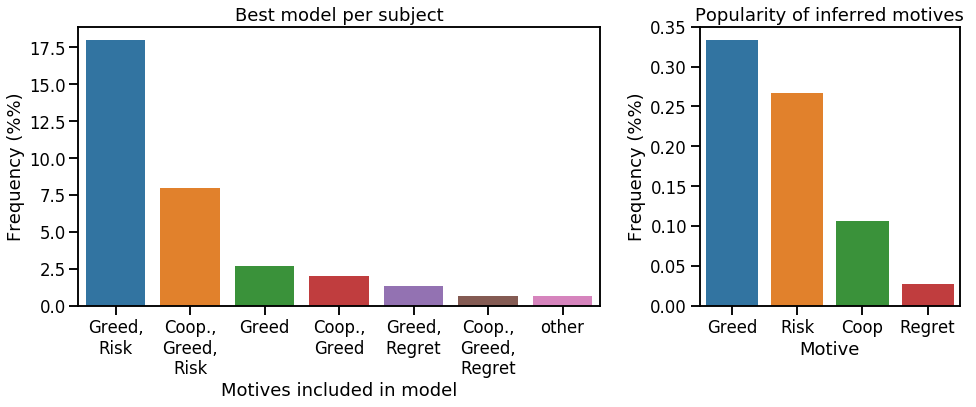

In [44]:
sns.set_context('talk')
fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = [14,6], gridspec_kw = {'width_ratios':[2,1]});
sns.barplot(data = bestModelCounts_aggTrunc, x='comb_labels', y='pct',
            order = bestModelCounts_aggTrunc.comb_labels, ax = ax[0],
           palette = 'tab10')
ax[0].set(xlabel = 'Motives included in model', ylabel = 'Frequency (%%)',
       title = 'Best model per subject');
ax[0].set_xticklabels(ax[0].get_xticklabels(),rotation=0)
sns.barplot(data = featureCounts, x='Motive', y='pct', ax = ax[1])
ax[1].set(xlabel = 'Motive', ylabel = 'Frequency (%%)',
       title = 'Popularity of inferred motives');
plt.tight_layout()
plt.savefig('/Users/jvanbaar/Desktop/modelComp_perSub_labels_pct_withFeatureCounts_study2.pdf',bbox_inches='tight',
           transparent = True)

## Store features per subject

In [53]:
bestPerSubject_features[['subID','Coop','Greed','Risk','Regret','comb','comb_labels']].to_csv(
    '/Users/jvanbaar/Dropbox (Brown)/Postdoc FHL/JEROEN/SOC_STRUCT_LEARN/Study2_EyeTracking/'+
    'Data/Cleaned/ModelFeaturesPerSubject.csv')

## Relationship between model features/complexity and performance

In [193]:
blockDat = blockDat.merge(bestPerSubject[['subID','nDim','comb']],on='subID')
blockDat.head()

,subID,Type_Total,Type,Variant,Confidence,Score,nDim_x,comb_x,nDim_y,comb_y
0,2003,opt_inv,opt,inv,50.625,0.4375,2,1100,2,1100
1,2003,opt_nat,opt,nat,89.375,1.0000,2,1100,2,1100
2,2003,pess_inv,pess,inv,50.000,0.5000,2,1100,2,1100
3,2003,pess_nat,pess,nat,52.500,0.5625,2,1100,2,1100
4,2004,opt_inv,opt,inv,53.125,0.2500,1,0100,1,0100


##### Merge data based on asymm_LR = 0, bounded_weights = 0, BIC (dataframe 'bestPerSubject')

In [194]:
totalDat = blockDat[['subID','Confidence','Score']].groupby(['subID']).mean().reset_index()
totalDat = totalDat.merge(bestPerSubject[['subID','nDim','comb']],on='subID')
totalDat.head()

,subID,Confidence,Score,nDim,comb
0,2003,60.62500,0.62500,2,1100
1,2004,62.03125,0.50000,1,0100
2,2005,61.71875,0.53125,1,0100
3,2006,45.15625,0.56250,1,0100
4,2008,75.00000,0.59375,1,0100


In [195]:
means = totalDat[['comb','nDim','Score']].groupby(['comb','nDim']).mean().sort_values(
    by='Score',ascending=False).reset_index()
combOrder = list(means['comb'].values)
print(combOrder)

['1111', '0111', '1110', '0010', '0110', '1101', '1010', '1001', '0100', '1100', '0101', '0011', '1011', '0001', '1000']


In [196]:
nDimOrder = list(means[['nDim','comb']].sort_values(by='nDim',ascending=False)['comb'].values)
print(nDimOrder)

['1111', '0111', '1110', '1101', '1011', '0110', '1010', '1001', '1100', '0101', '0011', '0010', '0100', '0001', '1000']


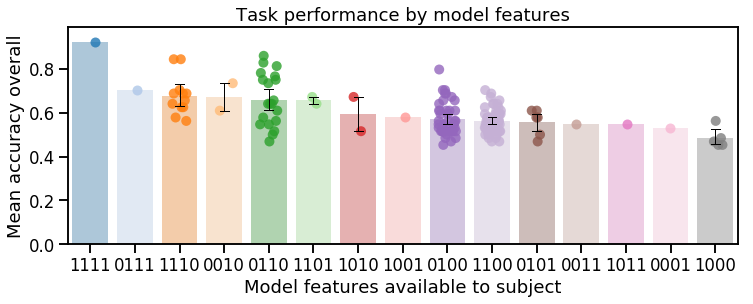

In [197]:
fig, ax = plt.subplots(nrows = 1, ncols = 1, figsize = [12,4]);
sns.set_palette('tab10')
sns.barplot(data = totalDat, x = 'comb', y = 'Score', ax=ax, order = combOrder,
           alpha = .4, errwidth = 0, zorder = 0, palette = 'tab20');
[hand, lab] = ax.get_legend_handles_labels();
sns.stripplot(data = totalDat, x = 'comb', y = 'Score', ax=ax, order = combOrder, dodge=True,
           alpha = 0.8, size = 10, jitter = .2, zorder = 1, palette = 'tab20');
sns.barplot(data = totalDat, x = 'comb', y = 'Score', ax=ax, order = combOrder,
           alpha = 0, errwidth = 1, capsize = .2, errcolor = 'k', zorder = 2, palette = 'tab20');
ax.set(xlabel = 'Model features available to subject', ylabel = 'Mean accuracy overall', 
      title = 'Task performance by model features');
# plt.savefig('/Users/jvanbaar/Desktop/PerformanceByFeatureSet.pdf',bbox_inches='tight',
#            transparent = True)

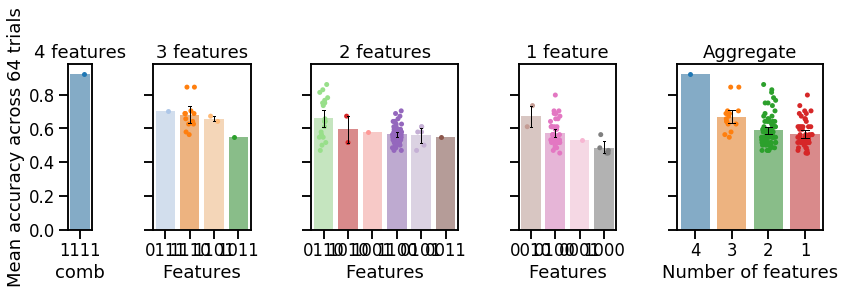

In [198]:
nCombsPernDim = [len(totalDat.query('nDim == @nDim')['comb'].unique()) for nDim in [4,3,2,1]]
nCombsPernDim.append(6)
fig, ax = plt.subplots(nrows = 1, ncols = 5, figsize = [12,4], sharey=True,
                       gridspec_kw={'width_ratios':nCombsPernDim});
nPast = 0
for ndi,nDim in enumerate([4,3,2,1]):
    nCombs = len(totalDat.query('nDim == @nDim')['comb'].unique())
    if nCombs > 1:
        means = totalDat.query('nDim == @nDim')[['comb','nDim','Score']].groupby(
            ['comb','nDim']).mean().sort_values(by='Score',ascending=False).reset_index()
        combOrder = list(means['comb'].values)
    else:
        combOrder = ['1111']
    sns.barplot(data = totalDat.query('nDim == @nDim'), y = 'Score', x='comb', ax=ax[ndi],
           alpha = .6, errwidth = 0, zorder = 0, order = combOrder,
           palette = sns.color_palette('tab20')[nPast:(nPast+nCombs)]);
    sns.stripplot(data = totalDat.query('nDim == @nDim'), y = 'Score', x='comb', ax=ax[ndi],
           alpha = 1, zorder = 1, order = combOrder, size = 5, jitter = .2,
           palette = sns.color_palette('tab20')[nPast:(nPast+nCombs)]);
    sns.barplot(data = totalDat.query('nDim == @nDim'), y = 'Score', x='comb', ax=ax[ndi],
           alpha = 0, errwidth = 1, errcolor = 'k', capsize = .1, zorder = 2, order = combOrder,
           palette = sns.color_palette('tab20')[nPast:(nPast+nCombs)]);
    nPast = nPast + nCombs
ax[0].set(ylabel = 'Mean accuracy across 64 trials')
[ax[i].set(ylabel = '', xlabel = 'Features') for i in [1,2,3]]

sns.barplot(data = totalDat, x = 'nDim', y = 'Score', order = [4,3,2,1], ax = ax[4],
           alpha = .6, errwidth = 0, zorder = 0)
sns.stripplot(data = totalDat, x = 'nDim', y = 'Score', order = [4,3,2,1], ax = ax[4],
           alpha = 1, size = 5, jitter = .2, zorder = 1)
sns.barplot(data = totalDat, x = 'nDim', y = 'Score', order = [4,3,2,1], ax = ax[4],
           alpha = 0, errwidth = 1, errcolor = 'k', capsize = .2, zorder = 3)
[ax[i].set(title = '%i features'%(4-i)) for i in [0,1,2]]
ax[3].set(title = '1 feature')
ax[4].set(title = 'Aggregate', ylabel = '', xlabel = 'Number of features')
plt.tight_layout()
# plt.savefig('/Users/jvanbaar/Desktop/PerformanceByFeatureCount.pdf',bbox_inches='tight',
#            transparent = True)

In [199]:
print(scipy.stats.spearmanr(totalDat['nDim'],totalDat['Score']))
print(scipy.stats.f_oneway(totalDat.query('nDim == 1')['Score'],
                     totalDat.query('nDim == 2')['Score'],
                    totalDat.query('nDim == 3')['Score'],
                    totalDat.query('nDim == 4')['Score']))

SpearmanrResult(correlation=0.30672617467890245, pvalue=0.00013474146942351567)
F_onewayResult(statistic=11.650509550337915, pvalue=6.86725357154285e-07)


##### Exclude single subject in ndim = 4

In [200]:
print(scipy.stats.spearmanr(totalDat.query('nDim < 4')['nDim'],
                            totalDat.query('nDim < 4')['Score']))
print(scipy.stats.f_oneway(totalDat.query('nDim == 2')['Score'],
                    totalDat.query('nDim == 3')['Score'],
                    totalDat.query('nDim == 4')['Score']))

SpearmanrResult(correlation=0.29093788157495504, pvalue=0.00031867260679701914)
F_onewayResult(statistic=13.188948876831097, pvalue=8.695123183837322e-06)


##### Best subject

In [201]:
totalDat.query('nDim == 4')['subID'].unique()

array(['2133'], dtype=object)

In [202]:
gameDat.query('subID == "2133"')[['Type_Total','SelfReport']].drop_duplicates()

NameError: name 'gameDat' is not defined

##### Performance by Opt/Pess

In [209]:
relevant_feature_dat = blockDat[['subID','Confidence','Score','Type_Total']].copy()
relevant_feature_dat = relevant_feature_dat.merge(bestPerSubject[['subID','nDim','comb']],on='subID')
relevant_feature_dat['has_greed'] = relevant_feature_dat['comb'].apply(lambda x: x[1] == '1')
relevant_feature_dat['has_risk'] = relevant_feature_dat['comb'].apply(lambda x: x[2] == '1')
relevant_feature_dat.head()

,subID,Confidence,Score,Type_Total,nDim,comb,has_greed,has_risk
0,2003,50.625,0.4375,opt_inv,2,1100,True,False
1,2003,89.375,1.0000,opt_nat,2,1100,True,False
2,2003,50.000,0.5000,pess_inv,2,1100,True,False
3,2003,52.500,0.5625,pess_nat,2,1100,True,False
4,2004,53.125,0.2500,opt_inv,1,0100,True,False


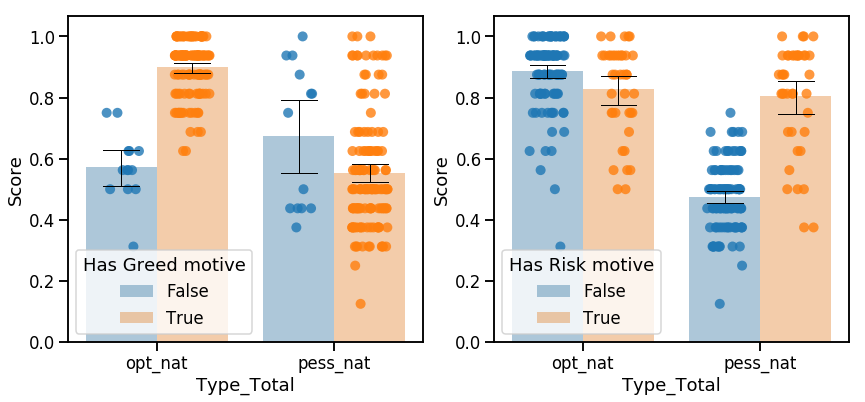

In [224]:
fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = [14,6]);
sns.set_palette('tab10')
sns.barplot(data = relevant_feature_dat, hue = 'has_greed', y = 'Score', x = 'Type_Total',
            order = ['opt_nat','pess_nat'],
            ax=ax[0], alpha = .4, errwidth = 0, zorder = 0);
[hand, lab] = ax[0].get_legend_handles_labels();
sns.stripplot(data = relevant_feature_dat, hue = 'has_greed', y = 'Score', x = 'Type_Total', ax=ax[0],
              order = ['opt_nat','pess_nat'],
              dodge=True, alpha = 0.8, size = 10, jitter = .2, zorder = 1);
sns.barplot(data = relevant_feature_dat, hue = 'has_greed', y = 'Score', ax=ax[0], x = 'Type_Total',
            order = ['opt_nat','pess_nat'],
           alpha = 0, errwidth = 1, capsize = .2, errcolor = 'k', zorder = 2, palette = 'tab20');
ax[0].legend(hand,lab,title = 'Has Greed motive')

sns.barplot(data = relevant_feature_dat, hue = 'has_risk', y = 'Score', x = 'Type_Total',
            order = ['opt_nat','pess_nat'],
            ax=ax[1], alpha = .4, errwidth = 0, zorder = 0);
[hand, lab] = ax[1].get_legend_handles_labels();
sns.stripplot(data = relevant_feature_dat, hue = 'has_risk', y = 'Score', x = 'Type_Total', ax=ax[1],
              order = ['opt_nat','pess_nat'],
              dodge=True, alpha = 0.8, size = 10, jitter = .2, zorder = 1);
sns.barplot(data = relevant_feature_dat, hue = 'has_risk', y = 'Score', ax=ax[1], x = 'Type_Total',
            order = ['opt_nat','pess_nat'],
           alpha = 0, errwidth = 1, capsize = .2, errcolor = 'k', zorder = 2, palette = 'tab20');
ax[1].legend(hand,lab,title = 'Has Risk motive')
# plt.legend(hand,lab, loc = [1.1,.5])
# ax.set(xlabel = 'Model features available to subject', ylabel = 'Mean accuracy overall', 
#       title = 'Task performance by model features');
# # plt.savefig('/Users/jvanbaar/Desktop/PerformanceByFeatureSet.pdf',bbox_inches='tight',
# #            transparent = True)

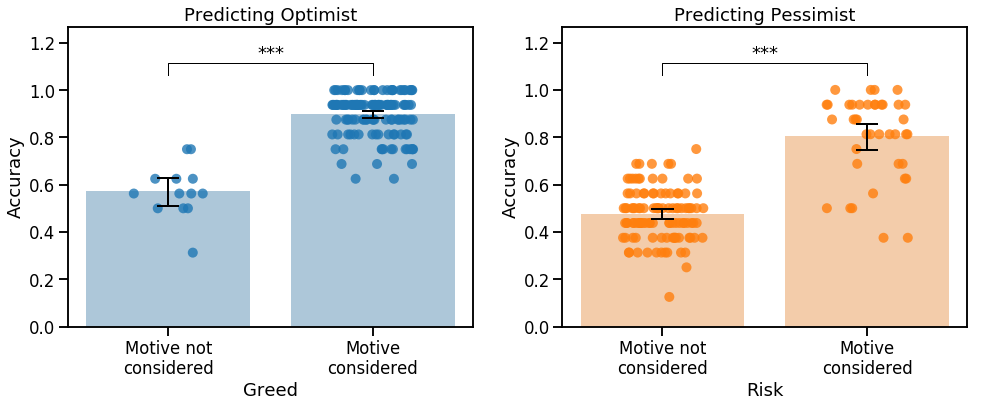

In [289]:
fig, axes = plt.subplots(nrows = 1, ncols = 2, figsize = [14,6]);
sns.set_palette('tab10')
player_types = ['opt_nat','pess_nat']
lf_player_types = ['Optimist','Pessimist']
motive_columns = ['has_greed','has_risk']
lf_motive_columns = ['Greed','Risk']
colors = sns.color_palette('tab10')[:2]
for ai, ax in enumerate(axes.ravel()):
    player_type = player_types[ai]
    motive_column = motive_columns[ai]
    tmp = relevant_feature_dat.query('Type_Total == @player_type').copy()
    sns.barplot(data = tmp,
            x = motive_column, y = 'Score', ax=ax, alpha = .4, errwidth = 0, zorder = 0,
               color = colors[ai]);
# [hand, lab] = ax[0].get_legend_handles_labels();
    sns.stripplot(data = tmp,
            x = motive_column, y = 'Score', ax=ax, alpha = 0.8, size = 10, jitter = .2, zorder = 1,
               color = colors[ai]);
    sns.barplot(data = tmp,
            x = motive_column, y = 'Score', ax=ax,
            alpha = 0, errwidth = 2, capsize = .1, errcolor = 'k', zorder = 2,
               color = colors[ai]);
    ax.set(title = 'Predicting %s'%lf_player_types[ai], ylabel = 'Accuracy',
           xticklabels = ['Motive not\nconsidered', 'Motive\nconsidered'],
          xlabel = lf_motive_columns[ai])
    
    ttest_results = scipy.stats.ttest_ind(tmp.loc[tmp[motive_column],'Score'],
                                          tmp.loc[~tmp[motive_column],'Score'])
    pval = ttest_results[1]
    FigureTools.add_sig_markers(ax, relationships = [[0,1,pval]])
plt.tight_layout()
plt.savefig('/Users/jvanbaar/Desktop/PerformanceByMotive.pdf',bbox_inches='tight',
           transparent = True)

## Relationship between model features/complexity and response time

In [149]:
gameDat = pd.read_csv('FeatureRL/gameDat.csv',index_col = 0, dtype={ 'subID':str})
gameDat.head()

,sub,subID,Block,Player,Type,Variant,Type_Total,Trial,S,T,GameType,Colors,CorrAns,GivenAns,ConfidenceNum,ScoreNum,RT_radio,RT_submit,SelfReport
0,3,2003,0,G.P.,opt,nat,opt_nat,0,3,12,PD,"['Blue', 'Red']",def,def,70,1,10439,14310,maximize own score
1,3,2003,0,G.P.,opt,nat,opt_nat,1,7,8,HG,"['Blue', 'Red']",coop,coop,80,1,5259,8262,maximize own score
2,3,2003,0,G.P.,opt,nat,opt_nat,2,3,8,SH,"['Blue', 'Red']",coop,coop,80,1,2764,5519,maximize own score
3,3,2003,0,G.P.,opt,nat,opt_nat,3,7,12,SG,"['Blue', 'Red']",def,def,80,1,4497,7794,maximize own score
4,3,2003,0,G.P.,opt,nat,opt_nat,4,0,15,PD,"['Blue', 'Red']",def,def,70,1,12523,16207,maximize own score


In [150]:
RTdat = gameDat[['subID','Type_Total','RT_radio','RT_submit']
               ].groupby(['subID','Type_Total']).sum().reset_index()
RTdat.head()

,subID,Type_Total,RT_radio,RT_submit
0,04000,opt_inv,51392,75526
1,04000,opt_nat,61995,90589
2,04000,pess_inv,64595,91490
3,04000,pess_nat,81852,108421
4,04001,opt_inv,36924,63762


In [151]:
RTdat = RTdat.merge(bestPerSubject[['subID','nDim','comb']],on='subID')
RTdat.head()

,subID,Type_Total,RT_radio,RT_submit,nDim,comb
0,2003,opt_inv,56686,97998,2,1100
1,2003,opt_nat,68547,121664,2,1100
2,2003,pess_inv,43563,87240,2,1100
3,2003,pess_nat,78001,127675,2,1100
4,2004,opt_inv,73840,98956,1,0100


##### Total game time

In [152]:
RTdatOverall = RTdat[['subID','RT_radio','RT_submit','nDim','comb']].groupby(['subID','nDim','comb']
                    ).sum().reset_index()
RTdatOverall.head()

,subID,nDim,comb,RT_radio,RT_submit
0,2003,2,1100,246797,434577
1,2004,1,0100,331818,457653
2,2005,1,0100,364659,534371
3,2006,1,0100,322376,432898
4,2008,1,0100,568010,699874


In [153]:
RTdatOverall_unitS = RTdatOverall.copy()
RTdatOverall_unitS['RT_radio'] = RTdatOverall_unitS['RT_radio']/1000
RTdatOverall_unitS['RT_submit'] = RTdatOverall_unitS['RT_submit']/1000
RTdatOverall_unitS.head()

,subID,nDim,comb,RT_radio,RT_submit
0,2003,2,1100,246.797,434.577
1,2004,1,0100,331.818,457.653
2,2005,1,0100,364.659,534.371
3,2006,1,0100,322.376,432.898
4,2008,1,0100,568.010,699.874


##### Remove outliers

In [154]:
RTdatOverall_unitS = RTdatOverall_unitS.query('RT_submit < 2000').copy()

##### Plot

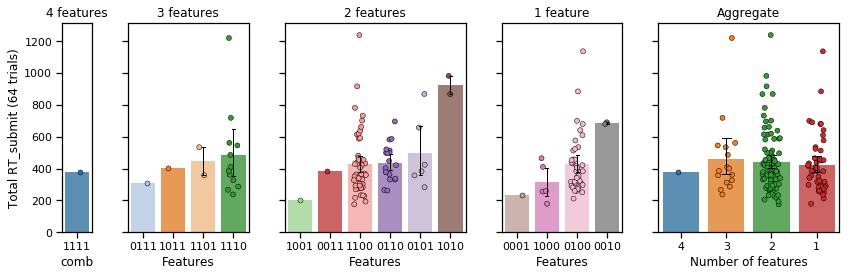

In [157]:
plotDat = RTdatOverall_unitS.copy()
RTchoice = 'RT_submit' # Can be 'RT_radio' or 'RT_submit'

nCombsPernDim = [len(plotDat.query('nDim == @nDim')['comb'].unique()) for nDim in [4,3,2,1]]
nCombsPernDim.append(6)
fig, ax = plt.subplots(nrows = 1, ncols = 5, figsize = [12,4], sharey=True,
                       gridspec_kw={'width_ratios':nCombsPernDim});
nPast = 0
for ndi,nDim in enumerate([4,3,2,1]):
    nCombs = len(plotDat.query('nDim == @nDim')['comb'].unique())
    if nCombs > 1:
        means = plotDat.query('nDim == @nDim')[['comb','nDim',RTchoice]].groupby(
            ['comb','nDim']).mean().sort_values(by=RTchoice,ascending=True).reset_index()
        combOrder = list(means['comb'].values)
    else:
        combOrder = ['1111']
    sns.barplot(data = plotDat.query('nDim == @nDim'), y = RTchoice, x='comb', ax=ax[ndi],
           alpha = .8, errwidth = 0, zorder = 0, order = combOrder,
           palette = sns.color_palette('tab20')[nPast:(nPast+nCombs)]);
    sns.stripplot(data = plotDat.query('nDim == @nDim'), y = RTchoice, x='comb', ax=ax[ndi],
           alpha = 1, zorder = 1, order = combOrder, size = 5, jitter = .2,
           edgecolor = 'k', linewidth=.5, palette = sns.color_palette('tab20')[nPast:(nPast+nCombs)]);
    sns.barplot(data = plotDat.query('nDim == @nDim'), y = RTchoice, x='comb', ax=ax[ndi],
           alpha = 0, errwidth = 1, errcolor = 'k', capsize = .1, zorder = 2, order = combOrder,
           palette = sns.color_palette('tab20')[nPast:(nPast+nCombs)]);
    nPast = nPast + nCombs
ax[0].set(ylabel = 'Total %s (64 trials)'%RTchoice)
[ax[i].set(ylabel = '', xlabel = 'Features') for i in [1,2,3]]

sns.barplot(data = plotDat, x = 'nDim', y = RTchoice, order = [4,3,2,1], ax = ax[4],
           alpha = .8, errwidth = 0, zorder = 0)
sns.stripplot(data = plotDat, x = 'nDim', y = RTchoice, order = [4,3,2,1], ax = ax[4],
           alpha = 1, size = 5, jitter = .2, zorder = 1, edgecolor = 'k', linewidth=.5)
sns.barplot(data = plotDat, x = 'nDim', y = RTchoice, order = [4,3,2,1], ax = ax[4],
           alpha = 0, errwidth = 1, errcolor = 'k', capsize = .2, zorder = 3)
[ax[i].set(title = '%i features'%(4-i)) for i in [0,1,2]]
ax[3].set(title = '1 feature')
ax[4].set(title = 'Aggregate', ylabel = '', xlabel = 'Number of features')
plt.tight_layout()
plt.savefig('/Users/jvanbaar/Desktop/RTByFeatureCount.pdf',bbox_inches='tight',
           transparent = True)

In [156]:
print(scipy.stats.pearsonr(RTdatOverall_unitS['nDim'],RTdatOverall_unitS['RT_submit']))
print(scipy.stats.f_oneway(RTdatOverall_unitS.query('nDim == 1')['RT_submit'],
                     RTdatOverall_unitS.query('nDim == 2')['RT_submit'],
                    RTdatOverall_unitS.query('nDim == 3')['RT_submit'],
                    RTdatOverall_unitS.query('nDim == 4')['RT_submit']))

(0.05295974648809967, 0.524080185810299)
F_onewayResult(statistic=0.21882522439683208, pvalue=0.8832086655609299)


## Which dimensions are used by people from the Coop, Opt, and Pess groups (self-report)?

In [127]:
baseDir = '/Users/jvanbaar/Dropbox (Brown)/Postdoc FHL/JEROEN/SOC_STRUCT_LEARN/'

In [128]:
DIYquiz = pd.read_csv(baseDir+'Study1_MTurk/Data/Cleaned/DIYquiz.csv',
                      dtype = {'subID':str}, index_col=0)
DIYquiz.head()

,sub,subID,selfType,typicalType
0,3,2003,opt,opt
1,4,2004,trust,none
2,5,2005,trust,trust
3,6,2006,trust,trust
4,8,2008,none,none


In [129]:
type(DIYquiz['subID'].values[0])

str

In [130]:
DIYquiz = DIYquiz.merge(bestPerSubject[['subID','comb','nDim']], on='subID')
DIYquiz.head()

,sub,subID,selfType,typicalType,comb,nDim
0,3,2003,opt,opt,1100,2
1,4,2004,trust,none,0100,1
2,5,2005,trust,trust,0100,1
3,6,2006,trust,trust,0100,1
4,8,2008,none,none,0100,1


In [131]:
combs = DIYquiz['comb'].unique()
combs.sort()
combs

array(['0001', '0010', '0011', '0100', '0101', '0110', '0111', '1000',
       '1001', '1010', '1011', '1100', '1101', '1110', '1111'],
      dtype=object)

In [175]:
combCountsAll = pd.DataFrame(columns=combs, index=DIYquiz['selfType'].unique())
combCountsAll[:] = 0
combCountsAll
for st in DIYquiz['selfType'].unique():
    combCounts = DIYquiz.loc[DIYquiz['selfType']==st,'comb'].value_counts(dropna=False)
    for comb in combCounts.index.values:
        combCountsAll.loc[st, comb] = combCounts[comb]
combCountsAll

,0001,0010,0011,0100,0101,0110,0111,1000,1001,1010,1011,1100,1101,1110,1111
opt,1,0,0,8,1,2,0,0,0,1,1,9,0,1,0
trust,0,0,0,21,2,4,1,2,1,0,0,28,2,4,0
none,0,1,0,10,3,3,0,2,0,0,0,10,0,4,0
other_opt,0,1,0,1,0,3,0,0,0,1,0,3,0,1,0
pess,0,0,0,1,0,6,0,0,0,0,0,2,0,2,1
env,0,0,1,1,0,1,0,1,0,0,0,0,0,0,0


In [176]:
# combCountsAll = combCountsAll.iloc[[0,4,1],:]
combCountsAll_other = pd.DataFrame(combCountsAll.iloc[[2,3,5],:].sum(axis=0))
combCountsAll_other.columns = ['other']
combCountsAll_other = combCountsAll_other.T
# combCountsAll_other
combCountsAll = combCountsAll.iloc[[0,4,1],:].append(combCountsAll_other)
combCountsAll
# fbg_red = fbg_red.append(mean_other)

,0001,0010,0011,0100,0101,0110,0111,1000,1001,1010,1011,1100,1101,1110,1111
opt,1,0,0,8,1,2,0,0,0,1,1,9,0,1,0
pess,0,0,0,1,0,6,0,0,0,0,0,2,0,2,1
trust,0,0,0,21,2,4,1,2,1,0,0,28,2,4,0
other,0,2,1,12,3,7,0,3,0,1,0,13,0,5,0


In [177]:
combCountsAllShare = combCountsAll.copy()
for st in combCountsAllShare.index:
#     vals = combCountsAllShare.loc[st,:].values
    combCountsAllShare.loc[st,:] = np.divide(combCountsAllShare.loc[st,:], 
                                 np.sum(combCountsAllShare.loc[st,:].values))
combCountsAllShare

,0001,0010,0011,0100,0101,0110,0111,1000,1001,1010,1011,1100,1101,1110,1111
opt,0.041667,0.000000,0.000000,0.333333,0.041667,0.083333,0.000000,0.000000,0.000000,0.041667,0.041667,0.375000,0.000000,0.041667,0.000000
pess,0.000000,0.000000,0.000000,0.083333,0.000000,0.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.166667,0.000000,0.166667,0.083333
trust,0.000000,0.000000,0.000000,0.323077,0.030769,0.061538,0.015385,0.030769,0.015385,0.000000,0.000000,0.430769,0.030769,0.061538,0.000000
other,0.000000,0.042553,0.021277,0.255319,0.063830,0.148936,0.000000,0.063830,0.000000,0.021277,0.000000,0.276596,0.000000,0.106383,0.000000


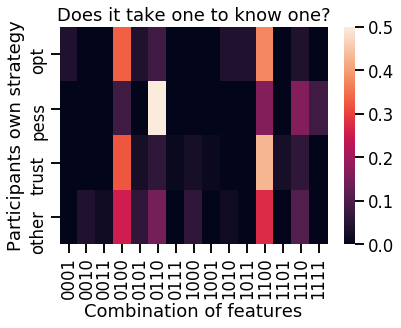

In [178]:
sns.set_context('talk')
fig, ax = plt.subplots(nrows = 1, ncols = 1);
sns.heatmap(combCountsAllShare, ax=ax)
ax.set(xlabel = 'Combination of features', ylabel = 'Participant''s own strategy', 
       title = 'Does it take one to know one?');
# plt.savefig('/Users/jvanbaar/Desktop/featuresByOwnType.pdf',bbox_inches='tight');

In [184]:
combs_considered = combCountsAllShare.columns
featuresByGroup = pd.DataFrame(columns=[0,1,2,3], index = combCountsAllShare.index)
featuresByGroup[:] = 0
for feature in [0,1,2,3]:
    columnsToCheck = []
    for comb in combs_considered:
        if comb[feature]=='1':
            columnsToCheck.append(comb)
    for st in combCountsAllShare.index:
        featuresByGroup.loc[st, feature] = np.sum(combCountsAllShare.loc[st, columnsToCheck])
featuresByGroup = featuresByGroup*100
featuresByGroup

,0,1,2,3
opt,50.000000,87.500000,20.833333,12.500000
pess,41.666667,100.000000,75.000000,8.333333
trust,56.923077,95.384615,13.846154,9.230769
other,46.808511,85.106383,34.042553,8.510638


In [185]:
# fbg_red = featuresByGroup.iloc[[0,4,1],:]
# mean_other = pd.DataFrame(featuresByGroup.iloc[[2,3,5],:].mean(axis=0))
# mean_other.columns = ['other']
# mean_other = mean_other.T
# fbg_red = fbg_red.append(mean_other)
# fbg_red

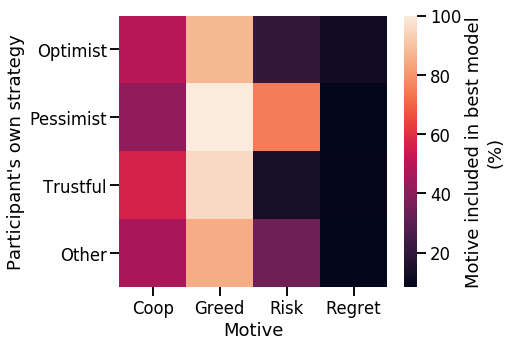

In [192]:
sns.set_context('talk')
fig, ax = plt.subplots(nrows = 1, ncols = 1, figsize = [6,5]);
sns.heatmap(featuresByGroup, ax=ax, cbar_kws = {'label':'Motive included in best model\n(%)'})
ax.set(xlabel = 'Motive', ylabel = 'Participant\'s own strategy', 
#        title = 'Frequency of motives inferred',
       xticklabels = ['Coop','Greed','Risk','Regret'],
      yticklabels = ['Optimist','Pessimist','Trustful','Other']
      );
plt.yticks(rotation = 0);
plt.savefig('/Users/jvanbaar/Desktop/featuresByOwnType_reduced_pct.pdf',bbox_inches='tight',
           transparent = True);